In [1]:
import numpy as np
from glob import glob
from skimage import measure
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from skimage.draw import polygon

from matplotlib.animation import FuncAnimation

In [2]:
output = [11 + i*6 for i in range(7)]

In [3]:
def loadimage(file):
    matrix = np.genfromtxt(file).T
    return matrix

def normimage(matrix):
    min_ = matrix.min()
    matrix = (matrix - min_) / (matrix.max() - min_)
    return abs(1 - matrix)

In [4]:
w_images = np.array([loadimage("Tungsteno/%dkV_1.txt"%i) for i in output])
ff_w = np.array([loadimage("Tungsteno/%dkV_2.txt"%i) for i in output])
ag_images = np.array([loadimage("Plata/%dkV_1.txt"%i) for i in output])
ff_ag = np.array([loadimage("Plata/%dkV_2.txt"%i) for i in output])

In [5]:
ag_images[-1] = (ag_images[-1] + ag_images[-2]) / 2

In [6]:
norm_w = w_images / (ff_w + 1)
norm_ag = ag_images / (ff_ag + 1)

for i in range(len(output)):
    norm_w[i] = normimage(norm_w[i])
    norm_ag[i] = normimage(norm_ag[i])

# All in one

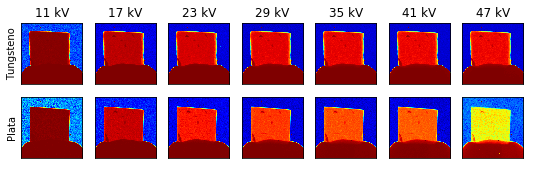

In [7]:
cmap = "jet"

fig, (ax1, ax2) = plt.subplots(2, 7, figsize = (9, 2.5))

for i in range(7):
    ax1[i].imshow(norm_w[i], vmin = 0, vmax = 1, cmap = cmap)
    ax2[i].imshow(norm_ag[i], vmin = 0, vmax = 1, cmap = cmap)
    
    ax1[i].set_title("%d kV"%output[i])
    ax1[i].set_yticks([])
    ax1[i].set_yticklabels([])
    ax1[i].set_xticks([])
    ax1[i].set_xticklabels([])
    ax2[i].set_yticks([])
    ax2[i].set_yticklabels([])
    ax2[i].set_xticks([])
    ax2[i].set_xticklabels([])
    
ax1[0].set_ylabel("Tungsteno")
ax2[0].set_ylabel("Plata")

# fig.savefig("Images.png")

plt.show()

# Two in one

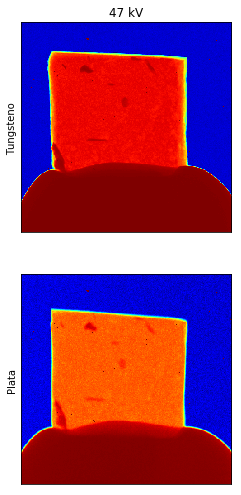

In [8]:
cmap = "jet"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (4, 8.5))

ax1.imshow(norm_w[-2], vmin = 0, vmax = 1, cmap = cmap)
ax2.imshow(norm_ag[-2], vmin = 0, vmax = 1, cmap = cmap)

ax1.set_title("%d kV"%output[i])
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_xticklabels([])
    
ax1.set_ylabel("Tungsteno")
ax2.set_ylabel("Plata")

# fig.savefig("ImagesCol.png")

plt.show()

In [9]:
filt_w = medfilt(norm_w, (1, 7, 7))
filt_ag = medfilt(norm_ag, (1, 7, 7))

In [10]:
def get_mask(rr, cc, X, Y, extra = 5):
    mask = np.zeros_like(X)
    
    h_min = rr.min() - extra
    h_max = rr.max() + extra
    w_min = cc.min() - extra
    w_max = cc.max() + extra

    pos = (Y > h_min) & (Y < h_max) & (X > w_min) & (X < w_max)

    mask[pos] = 1
    mask[rr, cc] = 0
    
    return mask

In [11]:
def get_contrast(array, threshold, ax, extra = 5):
    constrasts = np.zeros(array.shape[0] - 1)
    for i in range(array.shape[0] - 1):
        r = array[i + 1]
        contours = measure.find_contours(r, threshold[i])

        # Display the image and plot all contours found
        
        ax[i].imshow(r, interpolation='nearest', cmap="jet")

        x = y = np.arange(r.shape[0])
        X, Y = np.meshgrid(x, y)

        inside_sum = 0
        outside_sum = 0
        sizes = 0 
        
        masks = np.zeros_like(X)

        for n, contour in enumerate(contours):
            size = contour.shape[0]
            if (size < 100) and (size > 10): 
                rr, cc = polygon(contour[:,0], contour[:,1], r.shape)

                mask = get_mask(rr, cc, X, Y, extra = extra)

                inside = r[rr, cc]
                outside = r[mask == 1]

                inside_sum += size * inside.mean()
                outside_sum += size * outside.mean()
                sizes += size
                
                masks += mask
                ax[i].plot(contour[:, 1], contour[:, 0], linewidth = 0.5, c = "k")

        try:
            inside_sum *= 1/sizes
            outside_sum *= 1/sizes
            
            constrasts[i] = 100*(inside_sum - outside_sum)
        except:
            constrasts[i] = 0
            
        ax[i].imshow(masks, cmap = "jet", alpha = 0.6)

        ax[i].axis('image')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        ax[i].set_title("%.2f"% constrasts[i])
        
    return constrasts


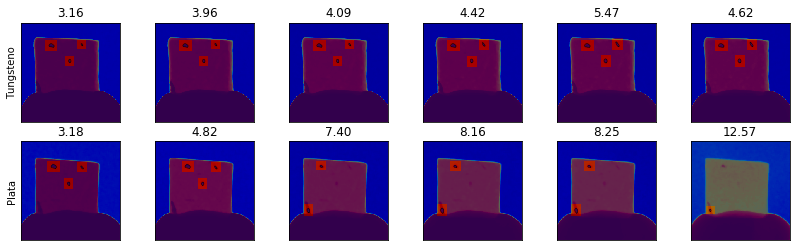

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 6, figsize = (2*7, 4))

c_w = get_contrast(filt_w, [0.97, 0.95, 0.94, 0.93, 0.92, 0.92], ax1, extra = 10)
c_ag = get_contrast(filt_ag, [0.96, 0.92, 0.945, 0.92, 0.91, 0.8], ax2, extra = 10)

ax1[0].set_ylabel("Tungsteno")
ax2[0].set_ylabel("Plata")

plt.savefig("ContrasteImages.png")
plt.show()

0.057755580469081226 0.025579329658339627
2.4392678060851654 0.8594807021768114
0.27619070761691134 0.059404690536914814
-1.442621195415817 1.9960329616619783


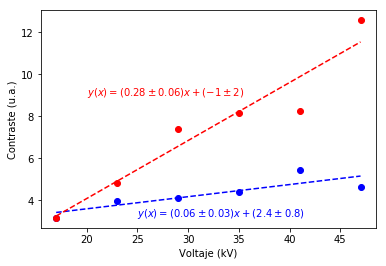

In [13]:
x = np.array(output[1:])

(m, b), cov = np.polyfit(x, c_w, 1, cov = True)

dm = cov[0, 0]**0.5
db = cov[1, 1]**0.5

y = m * x + b

print(m, dm)
print(b, db)

plt.plot(x, c_w, "o", c = "b", label = "Tungsteno")
plt.plot(x, y, "--", c = "b")
plt.text(25, 3.2, "$y(x) = (0.06 \pm 0.03)x + (2.4 \pm 0.8)$", color = "b")


(m, b), cov = np.polyfit(x, c_ag, 1, cov = True)

dm = cov[0, 0]**0.5
db = cov[1, 1]**0.5

y = m * x + b

print(m, dm)
print(b, db)

plt.plot(x, c_ag, "o", c = "r", label = "Plata")
plt.plot(x, y, "--", c = "r")
plt.text(20, 9, "$y(x) = (0.28 \pm 0.06)x + (-1 \pm 2)$", color = "r")


plt.xlabel("Voltaje (kV)")
plt.ylabel("Contraste (u.a.)")

plt.savefig("Contraste.png")
plt.show()